# 🎂 Segmind Challenge : Prediction of Sales of each Store🎂

## TO DO:

> Predict store sales of a store using the given dataset.

## Data:
> Dataset Given

* The dataset consists of 4 CSV files:
* TRAIN.csv : (./dataset/TRAIN.csv)
* TEST.csv: (./dataset/TEST.csv)
* store.csv - additional information regarding the stores: (./dataset/store.csv)

## Evaluate:
* Time-series prediction problem.
* Sales has direct correlation to OPEN or not

## Features:
> From Test data

* Store: Store number
* DayOfWeek: Day (out of 7) per week
* Date: DD-MM-YYYY format
* Open: 1 for open, 0 for close
* Promo: 0 or 1 
* StateHoliday: 0, a, b, c (0 or store type)
* SchoolHoliday: 0 or 1

## 🤳Imports

In [12]:
# Essentials
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from dateutil.parser import parse
from math import ceil
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pprint import pprint

import pickle

## 💚Inputs

In [13]:
# Store data
def import_store():
    storedf = pd.read_csv('./dataset/store.csv')
    return storedf
# Sales data
def import_data(x):
    df = pd.read_csv('./dataset/'+x+'.csv')
    return df

## 💌Total preprocessing

In [14]:
# Store attributes
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_with_store = ['Store','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
num_attribs = ["CompetitionDistance",
               "CompetitionOpenSinceMonth",
               "CompetitionOpenSinceYear",
               "Promo2SinceWeek",
               "Promo2SinceYear"]
# scale_attribs = ["CompetitionDistance"]
obj_attribs = ["StoreType", "Assortment"]

In [15]:
# Store Pipelines

# cd_pipeline_median = Pipeline([
#     ("imputer", SimpleImputer(strategy='median')),
#     ("stdscale", StandardScaler())
# ])

# cd_pipeline_mean = Pipeline([
#     ("imputer", SimpleImputer(strategy='mean')),
#     ("stdscale", StandardScaler())
# ])

# cd_pipeline_mode = Pipeline([
#     ("imputer", SimpleImputer(strategy='most_frequent')),
#     ("stdscale", StandardScaler())
# ])

full_pipeline_median = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mean = ColumnTransformer([
    ("num", SimpleImputer(strategy='mean'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mode = ColumnTransformer([
    ("num", SimpleImputer(strategy='most_frequent'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

In [16]:
# Sore Preprocessing

def divide_promointerval():
    '''
    1. Fillna with '0' in PROMOINTERVAL
    2. Dividing PromoInterval into months and applying custom one hot encoding
    4. Drop PROMOINTERVAL
    ----------
    PARAMETERS
    ----------
    NA
    -------
    RETURNS
    -------    
    test: DF after divinding the Promointerval into months
    '''
    store['PromoInterval'].fillna(value='0', inplace=True)
    test = pd.DataFrame(data=store.Store, columns=months_with_store)
    for month in months:
        test[month] = np.where(store["PromoInterval"].str.contains(month), 1, 0)
    if 'PromoInterval' in store.columns:    
        store.drop('PromoInterval', inplace=True, axis=1)    
    return test

def drop_store_columns():
    '''
    Dropping columns after preprocessing.
    '''
    for attri in num_attribs:
        if attri in store.columns:
            store.drop(attri, inplace=True, axis=1)
    for attri in obj_attribs:
        if attri in store.columns:
            store.drop(attri, inplace=True, axis=1)         

In [17]:
# Store transformation
store = import_store()
store_tranformed = full_pipeline_median.fit_transform(store)
drop_store_columns()
store_prepared = pd.DataFrame(data=store_tranformed, columns=(num_attribs+obj_attribs), index=store.index)
store = store.join(store_prepared)
month_df = divide_promointerval()
store_df = pd.merge(left=store, right=month_df, on='Store')

In [18]:
# Data Preprocessing
def week_of_month(tgtdate):
    date = parse(tgtdate)
    first_day = date.replace(day=1)

    day_of_month = date.day

    if(first_day.weekday() == 6):
        adjusted_dom = (1 + first_day.weekday()) / 7
    else:
        adjusted_dom = day_of_month + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def change_tf(true_false):
    if true_false == True:
        return 1
    else:
        return 0

def date_preproccesing():
    train_df['year'] = pd.DatetimeIndex(train_df['Date']).year
    train_df['month'] = pd.DatetimeIndex(train_df['Date']).month
    train_df['quarter'] = pd.DatetimeIndex(train_df['Date']).quarter
    train_df['dayofyear'] = pd.DatetimeIndex(train_df['Date']).dayofyear
    train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
    train_df['week'] = pd.DatetimeIndex(train_df['Date']).week
    train_df['is_month_start'] = pd.DatetimeIndex(train_df['Date']).is_month_start
    train_df['is_month_end'] = pd.DatetimeIndex(train_df['Date']).is_month_end
    train_df['is_year_end'] = pd.DatetimeIndex(train_df['Date']).is_year_end
    train_df['is_year_start'] = pd.DatetimeIndex(train_df['Date']).is_year_start
    train_df["StateHoliday"] = train_df["StateHoliday"].apply(lambda x: str(x))
    train_df["WeekOfMonth"] = train_df["Date"].apply(week_of_month)
    train_df["is_month_start"] = train_df["is_month_start"].apply(lambda x: change_tf(x))
    train_df["is_month_end"] = train_df["is_month_end"].apply(lambda x: change_tf(x))
    train_df["is_year_end"] = train_df["is_year_end"].apply(lambda x: change_tf(x))
    train_df["is_year_start"] = train_df["is_year_start"].apply(lambda x: change_tf(x))

def cat_transformation(x):
    if 'train' in x:
        train_df['StateHolidayCat'] = labelencoder.fit_transform(train_df['StateHoliday'])
    else:
        train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])

def drop_data_columns():
    if 'Date' in train_df.columns:
        train_df.drop('Date', inplace=True, axis=1)
    if 'StateHoliday' in train_df.columns:
        train_df.drop('StateHoliday', axis=1, inplace=True)
    if 'Customers' in train_df.columns:
        train_df.drop('Customers', axis=1, inplace=True)

In [19]:
labelencoder = LabelEncoder()

In [36]:
# Data transformation
# labelencoder = LabelEncoder()
train_or_test = 'test' #'test' 'train'
train_df = import_data(train_or_test)
date_preproccesing()
if 'train' in train_or_test:
    labelencoder.fit(train_df['StateHoliday'])
    train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
#     labelencoder.fit_transform(train_df['StateHoliday'])
else:
    train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
# train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
# cat_transformation(train_or_test)
drop_data_columns()

<ipython-input-18-1c317fd3e691>:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
<ipython-input-18-1c317fd3e691>:27: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['week'] = pd.DatetimeIndex(train_df['Date']).week


In [37]:
# Final_df
# final_df = pd.merge(left=train_df, right=store_df, on='Store')
final_df = pd.merge(train_df, store_df, how='left', left_on='Store', right_on='Store')
# final_df.drop('Store', axis=1, inplace=True)

In [38]:
final_df.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'year', 'month',
       'quarter', 'dayofyear', 'weekofyear', 'week', 'is_month_start',
       'is_month_end', 'is_year_end', 'is_year_start', 'WeekOfMonth',
       'StateHolidayCat', 'Promo2', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear', 'StoreType', 'Assortment', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec'],
      dtype='object')

In [39]:
# Dropping columns with respect to feature importance
columns_to_drop = ['Open', 'month','quarter', 'is_month_start', 
                   'is_year_end', 'is_year_start','StateHolidayCat','Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec']

In [40]:
for attri in columns_to_drop:
    if attri in final_df.columns:
        final_df.drop(attri, inplace=True, axis=1)

In [41]:
final_df.columns

Index(['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'year', 'dayofyear',
       'weekofyear', 'week', 'is_month_end', 'WeekOfMonth', 'Promo2',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'StoreType', 'Assortment'],
      dtype='object')

## 🎁Modelling

In [26]:
# Splitting the data
X = final_df.drop('Sales', axis=1)
y = final_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
RFR = RandomForestRegressor(n_estimators=150, max_depth=80, min_samples_leaf=2, min_samples_split=5, bootstrap=False, verbose=2)
RFR.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 10.0min finished


RandomForestRegressor(bootstrap=False, max_depth=80, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150, verbose=2)

In [28]:
pickle.dump(RFR, open("RFModel3.pkl","wb"))

In [29]:
load_model_random_rf = pickle.load(open('RFModel3.pkl','rb'))

In [5]:
load_model_random_rf.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state',
 'ccp_alpha')

In [32]:
columns = ['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'year',
       'dayofyear', 'weekofyear', 'week', 'is_month_end', 'WeekOfMonth',
       'Promo2', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'StoreType', 'Assortment']

<AxesSubplot:>

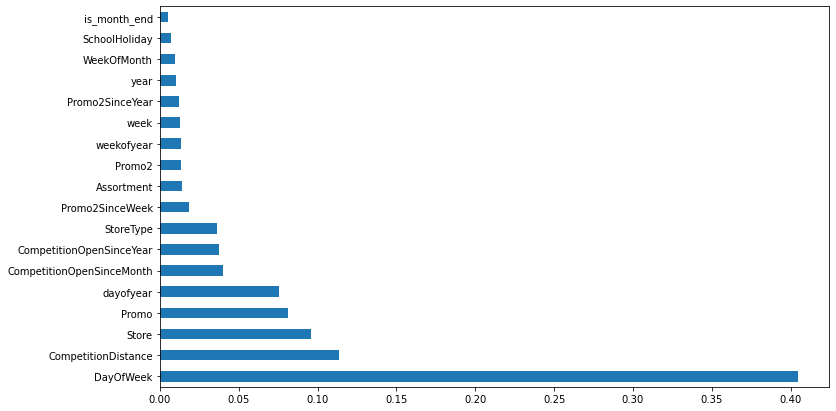

In [33]:
(pd.Series(load_model_random_rf.feature_importances_, index=columns)
 .nlargest(50)
   .plot(kind='barh', figsize=(12,7))) 

In [ ]:
columns_to_drop = ['Open', 'month','quarter', 'is_month_start', 
                   'is_year_end', 'is_year_start','StateHolidayCat','Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec']

In [34]:
load_model_random_rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    9.2s finished


0.8379052026856333

In [35]:
mean_squared_error(y_test, load_model_random_rf.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    9.1s finished


2495330.8818656546

In [42]:
# Testing
results = load_model_random_rf.predict(final_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.9s finished


In [43]:
df_results = pd.DataFrame(results, index = None)
#Remove all negative
df_results[df_results < 0] = 0
df_results["Index"]=range(0, len(df_results))
df_results.columns=["Sales","Index"]

columns_titles = ["Index","Sales"]
df_results=df_results.reindex(columns=columns_titles)
#Apply Up on the Sales column
df_results['Sales'] = df_results['Sales'].apply(np.ceil)
print(df_results.info())
print(df_results.head())
df_results.to_csv("outputm4.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305163 entries, 0 to 305162
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Index   305163 non-null  int32  
 1   Sales   305163 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 3.5 MB
None
   Index   Sales
0      0     0.0
1      1  3481.0
2      2  5915.0
3      3  4093.0
4      4  7251.0
